# 최근접 이웃(K-Nearest Neighbor)

* 특별한 예측 모델 없이 가장 가까운 데이터 포인트를 기반으로 예측을 수행하는 방법
* 분류와 회귀 모두 지원
 
![k nearest neighbor](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/220px-KnnClassification.svg.png)

In [1]:
import multiprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid'])
import seaborn as sns

In [2]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVR, SVC
from sklearn.datasets import load_boston, load_diabetes, load_breast_cancer, load_iris, load_wine
from sklearn.datasets import fetch_california_housing
from sklearn.pipeline import make_pipeline, Pipeline # 개체도가져온것
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE # ->시각화를 위해서 

In [3]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
oHe = OneHotEncoder()
ct = ColumnTransformer(transformers=[('encode',oHe,[0])],remainder='passthrough')

## K 최근접 이웃 분류

* 입력 데이터 포인트와 가장 가까운 k개의 훈련 데이터 포인트가 출력
* k개의 데이터 포인트 중 가장 많은 클래스가 예측 결과

### 붓꽃 데이터

In [4]:
iris = load_iris()

In [5]:
iris_df = pd.DataFrame(data= iris.data, columns=iris.feature_names)
iris_df['Target'] = iris.target
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [6]:
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [7]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale =scaler.transform(X_test)
#train data fit 한후 test는 fit 된결과에 대하여 transform만

In [8]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

In [9]:
print("학습데이터점수:{}".format(model.score(X_train, y_train)))
print("평가데이터점수:{}".format(model.score(X_test, y_test)))

학습데이터점수:0.975
평가데이터점수:0.9666666666666667


In [10]:
model = KNeighborsClassifier()
model.fit(X_train_scale, y_train)

KNeighborsClassifier()

In [11]:
print("학습데이터점수:{}".format(model.score(X_train_scale, y_train)))
print("평가데이터점수:{}".format(model.score(X_test_scale, y_test)))

학습데이터점수:0.9583333333333334
평가데이터점수:0.9666666666666667


In [12]:
cross_validate(
    estimator=KNeighborsClassifier(), X=X, y=y, cv=5, n_jobs=multiprocessing.cpu_count(),
    verbose=True)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.4s finished


{'fit_time': array([0.0003922 , 0.0003202 , 0.0003891 , 0.00037193, 0.00037193]),
 'score_time': array([0.00087905, 0.00077271, 0.00076127, 0.00079894, 0.00078797]),
 'test_score': array([0.96666667, 1.        , 0.93333333, 0.96666667, 1.        ])}

In [13]:
param_grid = [{'n_neighbors' : [3, 5, 7],
               'weights' : ['uniform', 'distance'],
               'algorithm' : ['ball_tree', 'kd_tree', 'brute']}]


In [14]:
gs = GridSearchCV(estimator=KNeighborsClassifier(),
                  param_grid=param_grid,
                  n_jobs=multiprocessing.cpu_count(),
                  verbose=True)

In [15]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=8,
             param_grid=[{'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'n_neighbors': [3, 5, 7],
                          'weights': ['uniform', 'distance']}],
             verbose=True)

In [16]:
gs.best_estimator_

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=7)

In [17]:
print('Grid Search CV best score: {}'.format(gs.best_score_))

Grid Search CV best score: 0.9800000000000001


In [18]:
def make_meshgrid(x, y, h=0.2):
    x_min, x_max = x.min()-1, x.max()+1
    y_min, y_max = y.min()-1, y.max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

In [19]:
def plot_contours(clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

In [20]:
tsne = TSNE(n_components=2) #저차원 2개의 feature에 하나의y값으로 변환
X_comp = tsne.fit_transform(X)


/opt/homebrew/Caskroom/miniforge/base/envs/ps/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ps/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [21]:
iris_comp_df = pd.DataFrame(data=X_comp)
iris_comp_df['Target']= y
iris_comp_df

,0,1,Target
0,10.354055,20.039759,0
1,10.095903,22.743856,0
2,11.283078,22.526669,0
3,11.027470,22.978642,0
4,10.819771,19.904507,0
...,...,...,...
145,-6.537075,-8.017311,2
146,-4.938905,-10.918348,2
147,-6.001866,-8.831753,2
148,-8.118431,-9.115900,2


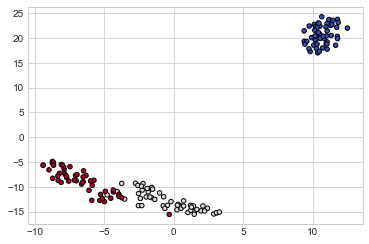

In [22]:
plt.scatter(X_comp[:, 0], X_comp[:,1],
            c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [23]:
model = KNeighborsClassifier()
model.fit(X_comp, y)
predict = model.predict(X_comp)

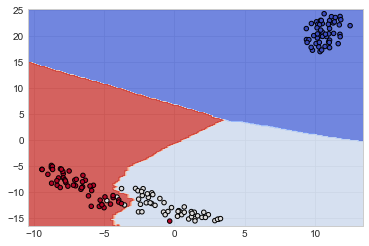

In [24]:
xx, yy = make_meshgrid(X_comp[:,0], X_comp[:,1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_comp[:,0], X_comp[:,1], c=y, cmap=plt.cm.coolwarm,
            s=20, edgecolors='k');

### 유방암 데이터

In [25]:
cancer = load_breast_cancer()

In [26]:
cancer_df = pd.DataFrame(data= cancer.data, columns=cancer.feature_names)
cancer_df['Target'] = cancer.target
cancer_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [27]:
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [28]:
# traindata가 몇개인지 확인 -> 80%
cancer_train_df = pd.DataFrame(data= X_train, columns=cancer.feature_names)
cancer_train_df['Target'] = y_train
cancer_train_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Target
0,15.78,22.91,105.70,782.6,0.11550,0.17520,0.21330,0.09479,0.2096,0.07331,...,30.50,130.30,1272.0,0.18550,0.4925,0.73560,0.20340,0.3274,0.12520,0
1,18.01,20.56,118.40,1007.0,0.10010,0.12890,0.11700,0.07762,0.2116,0.06077,...,26.06,143.40,1426.0,0.13090,0.2327,0.25440,0.14890,0.3251,0.07625,0
2,19.40,23.50,129.10,1155.0,0.10270,0.15580,0.20490,0.08886,0.1978,0.06000,...,30.53,144.90,1417.0,0.14630,0.2968,0.34580,0.15640,0.2920,0.07614,0
3,13.98,19.62,91.12,599.5,0.10600,0.11330,0.11260,0.06463,0.1669,0.06544,...,30.80,113.90,869.3,0.16130,0.3568,0.40690,0.18270,0.3179,0.10550,0
4,14.34,13.47,92.51,641.2,0.09906,0.07624,0.05724,0.04603,0.2075,0.05448,...,16.90,110.40,873.2,0.12970,0.1525,0.16320,0.10870,0.3062,0.06072,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,11.60,24.49,74.23,417.2,0.07474,0.05688,0.01974,0.01313,0.1935,0.05878,...,31.62,81.39,476.5,0.09545,0.1361,0.07239,0.04815,0.3244,0.06745,1
451,14.19,23.81,92.87,610.7,0.09463,0.13060,0.11150,0.06462,0.2235,0.06433,...,34.85,115.00,811.3,0.15590,0.4059,0.37440,0.17720,0.4724,0.10260,0
452,25.73,17.46,174.20,2010.0,0.11490,0.23630,0.33680,0.19130,0.1956,0.06121,...,23.58,229.30,3234.0,0.15300,0.5937,0.64510,0.27560,0.3690,0.08815,0
453,13.46,28.21,85.89,562.1,0.07517,0.04726,0.01271,0.01117,0.1421,0.05763,...,35.63,97.11,680.6,0.11080,0.1457,0.07934,0.05781,0.2694,0.07061,1


In [29]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale =scaler.transform(X_test)
#train data fit 한후 test는 fit 된결과에 대하여 transform만

In [30]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

In [31]:
print("학습데이터점수:{}".format(model.score(X_train, y_train)))
print("평가데이터점수:{}".format(model.score(X_test, y_test)))

학습데이터점수:0.9538461538461539
평가데이터점수:0.9035087719298246


In [32]:
model = KNeighborsClassifier()
model.fit(X_train_scale, y_train)

KNeighborsClassifier()

In [33]:
print("학습데이터점수:{}".format(model.score(X_train_scale, y_train)))
print("평가데이터점수:{}".format(model.score(X_test_scale, y_test)))

학습데이터점수:0.9824175824175824
평가데이터점수:0.9473684210526315


In [34]:
esimator = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier()
)

cross_validate(
    estimator=esimator, X=X, y=y, cv=5, n_jobs=multiprocessing.cpu_count(),
    verbose=True)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.2s finished


{'fit_time': array([0.00066495, 0.00071812, 0.0006063 , 0.00079203, 0.00190187]),
 'score_time': array([0.00241017, 0.00269485, 0.00226688, 0.00239325, 0.00453305]),
 'test_score': array([0.96491228, 0.95614035, 0.98245614, 0.95614035, 0.96460177])}

In [35]:
pipe = Pipeline(
    [('scaler', StandardScaler()),
     ('model', KNeighborsClassifier())])


In [36]:
param_grid = [{'model__n_neighbors' : [3, 5, 7],
               'model__weights' : ['uniform', 'distance'],
               'model__algorithm' : ['ball_tree', 'kd_tree', 'brute']}]


In [37]:
gs = GridSearchCV(estimator=pipe,
                  param_grid=param_grid,
                  n_jobs=multiprocessing.cpu_count(),
                  verbose=True)

In [38]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsClassifier())]),
             n_jobs=8,
             param_grid=[{'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'model__n_neighbors': [3, 5, 7],
                          'model__weights': ['uniform', 'distance']}],
             verbose=True)

In [39]:
gs.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsClassifier(algorithm='ball_tree', n_neighbors=7))])

In [40]:
print('Grid Search CV best score: {}'.format(gs.best_score_))

Grid Search CV best score: 0.9701288619779538


In [41]:
tsne = TSNE(n_components=2) #저차원 2개의 feature에 하나의y값으로 변환
X_comp = tsne.fit_transform(X)


/opt/homebrew/Caskroom/miniforge/base/envs/ps/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ps/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [42]:
cancer_comp_df = pd.DataFrame(data=X_comp)
cancer_comp_df['Target']= y
cancer_comp_df

,0,1,Target
0,-33.013775,-9.755844,0
1,-30.329926,-10.485546,0
2,-29.532734,-5.809167,0
3,14.517934,-4.901677,0
4,-27.227459,-4.967022,0
...,...,...,...
564,-30.035536,-12.172904,0
565,-29.066761,-6.845190,0
566,-20.774544,10.017169,0
567,-29.989473,-8.315558,0


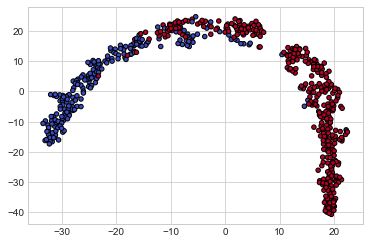

In [43]:
plt.scatter(X_comp[:, 0], X_comp[:,1],
            c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [44]:
model = KNeighborsClassifier()
model.fit(X_comp, y)
predict = model.predict(X_comp)

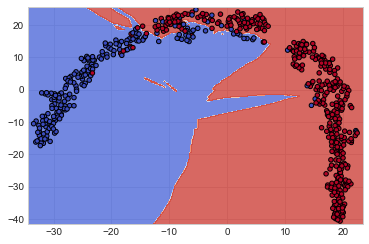

In [45]:
xx, yy = make_meshgrid(X_comp[:,0], X_comp[:,1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_comp[:,0], X_comp[:,1], c=y, cmap=plt.cm.coolwarm,
            s=20, edgecolors='k');

### Wine 데이터

In [46]:
wine = load_wine()

In [47]:
wine_df = pd.DataFrame(data= wine.data, columns=wine.feature_names)
wine_df['Target'] = wine.target
wine_df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


In [48]:
X, y = load_wine(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [49]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale =scaler.transform(X_test)
#train data fit 한후 test는 fit 된결과에 대하여 transform만

In [50]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

In [51]:
print("학습데이터점수:{}".format(model.score(X_train, y_train)))
print("평가데이터점수:{}".format(model.score(X_test, y_test)))

학습데이터점수:0.7887323943661971
평가데이터점수:0.7222222222222222


In [52]:
model = KNeighborsClassifier()
model.fit(X_train_scale, y_train)

KNeighborsClassifier()

In [53]:
print("학습데이터점수:{}".format(model.score(X_train_scale, y_train)))
print("평가데이터점수:{}".format(model.score(X_test_scale, y_test)))

학습데이터점수:0.9788732394366197
평가데이터점수:0.9722222222222222


In [54]:
esimator = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier()
)

cross_validate(
    estimator=esimator, X=X, y=y, cv=5, n_jobs=multiprocessing.cpu_count(),
    verbose=True)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.0s finished


{'fit_time': array([0.00061011, 0.00067997, 0.0006659 , 0.00142097, 0.00154996]),
 'score_time': array([0.00084591, 0.000875  , 0.00096416, 0.00251102, 0.00168204]),
 'test_score': array([0.94444444, 0.94444444, 0.97222222, 1.        , 0.88571429])}

In [55]:
pipe = Pipeline(
    [('scaler', StandardScaler()),
     ('model', KNeighborsClassifier())])


In [56]:
param_grid = [{'model__n_neighbors' : [3, 5, 7],
               'model__weights' : ['uniform', 'distance'],
               'model__algorithm' : ['ball_tree', 'kd_tree', 'brute']}]


In [57]:
gs = GridSearchCV(estimator=pipe,
                  param_grid=param_grid,
                  n_jobs=multiprocessing.cpu_count(),
                  verbose=True)

In [58]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsClassifier())]),
             n_jobs=8,
             param_grid=[{'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'model__n_neighbors': [3, 5, 7],
                          'model__weights': ['uniform', 'distance']}],
             verbose=True)

In [59]:
gs.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsClassifier(algorithm='ball_tree', n_neighbors=7))])

In [60]:
print('Grid Search CV best score: {}'.format(gs.best_score_))

Grid Search CV best score: 0.9665079365079364


In [61]:
tsne = TSNE(n_components=2) #저차원 2개의 feature에 하나의y값으로 변환
X_comp = tsne.fit_transform(X)


/opt/homebrew/Caskroom/miniforge/base/envs/ps/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ps/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [62]:
wine_comp_df = pd.DataFrame(data=X_comp)
wine_comp_df['Target']= y
wine_comp_df

,0,1,Target
0,-10.314785,-6.722544,0
1,-9.957604,-6.630138,0
2,-11.905694,-8.336252,0
3,-14.123723,-10.136153,0
4,-3.414337,-1.432435,0
...,...,...,...
173,-3.096875,-1.763049,2
174,-3.444496,-2.003544,2
175,-5.628950,-3.499011,2
176,-5.796953,-3.560563,2


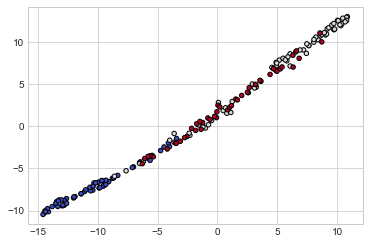

In [63]:
plt.scatter(X_comp[:, 0], X_comp[:,1],
            c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [64]:
model = KNeighborsClassifier()
model.fit(X_comp, y)
predict = model.predict(X_comp)

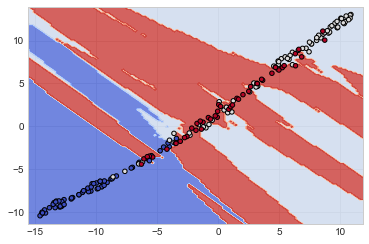

In [65]:
xx, yy = make_meshgrid(X_comp[:,0], X_comp[:,1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_comp[:,0], X_comp[:,1], c=y, cmap=plt.cm.coolwarm,
            s=20, edgecolors='k');

## k 최근접 이웃 회귀

* k 최근접 이웃 분류와 마찬가지로 예측에 이웃 데이터 포인트 사용
* 이웃 데이터 포인트의 평균이 예측 결과

### 보스턴 주택 가격 데이터

In [66]:
boston = load_boston()

/opt/homebrew/Caskroom/miniforge/base/envs/ps/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this case special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets incl

In [67]:
boston_df = pd.DataFrame(data= boston.data, columns=boston.feature_names)
boston_df['Target'] = boston.target
boston_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [68]:
X, y = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

/opt/homebrew/Caskroom/miniforge/base/envs/ps/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this case special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets incl

In [69]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale =scaler.transform(X_test)

model = KneighborsRegressor()
model.fit(X_train, y_train)

In [70]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)

KNeighborsRegressor()

In [71]:
print("학습데이터점수:{}".format(model.score(X_train, y_train)))
print("평가데이터점수:{}".format(model.score(X_test, y_test)))

학습데이터점수:0.6917111294476238
평가데이터점수:0.5885051557038379


In [72]:
model = KNeighborsRegressor()
model.fit(X_train_scale, y_train)

KNeighborsRegressor()

In [73]:
print("학습데이터점수:{}".format(model.score(X_train_scale, y_train)))
print("평가데이터점수:{}".format(model.score(X_test_scale, y_test)))

학습데이터점수:0.8374430142685984
평가데이터점수:0.7908851137621082


In [74]:
esimator = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor()
)

cross_validate(
    estimator=esimator, X=X, y=y, cv=5, n_jobs=multiprocessing.cpu_count(),
    verbose=True)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.0s finished


{'fit_time': array([0.00065589, 0.00044322, 0.00042224, 0.00049591, 0.00050306]),
 'score_time': array([0.00073695, 0.00068402, 0.00058293, 0.00063109, 0.00053191]),
 'test_score': array([0.56089547, 0.61917359, 0.48661916, 0.46986886, 0.23133037])}

In [75]:
pipe = Pipeline(
    [('scaler', StandardScaler()),
     ('model', KNeighborsRegressor())])


In [76]:
param_grid = [{'model__n_neighbors' : [3, 5, 7],
               'model__weights' : ['uniform', 'distance'],
               'model__algorithm' : ['ball_tree', 'kd_tree', 'brute']}]


In [77]:
gs = GridSearchCV(estimator=pipe,
                  param_grid=param_grid,
                  n_jobs=multiprocessing.cpu_count(),
                  verbose=True)

In [78]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsRegressor())]),
             n_jobs=8,
             param_grid=[{'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'model__n_neighbors': [3, 5, 7],
                          'model__weights': ['uniform', 'distance']}],
             verbose=True)

In [79]:
gs.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsRegressor(algorithm='brute', n_neighbors=7,
                                     weights='distance'))])

In [80]:
print('Grid Search CV best score: {}'.format(gs.best_score_))

Grid Search CV best score: 0.4973060611762847


In [81]:
tsne = TSNE(n_components=1) #저차원 2개의 feature에 하나의y값으로 변환
X_comp = tsne.fit_transform(X)


/opt/homebrew/Caskroom/miniforge/base/envs/ps/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ps/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [82]:
boston_comp_df = pd.DataFrame(data=X_comp)
boston_comp_df['Target']= y
boston_comp_df

,0,Target
0,-21.632673,24.0
1,-47.042202,21.6
2,-45.000725,34.7
3,-44.244179,33.4
4,-44.852154,36.2
...,...,...
501,-29.275620,22.4
502,-29.939993,20.6
503,-30.743898,23.9
504,-30.699770,22.0


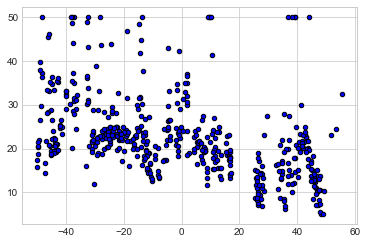

In [83]:
plt.scatter(X_comp[:, 0], y,
            c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [84]:
model = KNeighborsRegressor()
model.fit(X_comp, y)
predict = model.predict(X_comp)

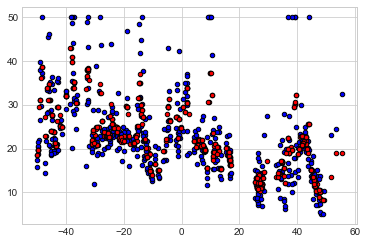

In [85]:
plt.scatter(X_comp[:, 0], y,
            c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k');
plt.scatter(X_comp[:, 0], predict,
            c='r', cmap=plt.cm.coolwarm, s=20, edgecolors='k');

### 캘리포니아 주택 가격 데이터

In [86]:
california = fetch_california_housing()

In [87]:
california_df = pd.DataFrame(data= california.data, columns=california.feature_names)
california_df['Target'] = california.target
california_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [88]:
X, y = fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [89]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale =scaler.transform(X_test)

In [90]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)

KNeighborsRegressor()

In [91]:
print("학습데이터점수:{}".format(model.score(X_train, y_train)))
print("평가데이터점수:{}".format(model.score(X_test, y_test)))

학습데이터점수:0.4435975807328706
평가데이터점수:0.1838848511272254


In [92]:
model = KNeighborsRegressor()
model.fit(X_train_scale, y_train)

KNeighborsRegressor()

In [93]:
print("학습데이터점수:{}".format(model.score(X_train_scale, y_train)))
print("평가데이터점수:{}".format(model.score(X_test_scale, y_test)))

학습데이터점수:0.7886807241651377
평가데이터점수:0.6971576488899968


In [94]:
esimator = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor()
)

cross_validate(
    estimator=esimator, X=X, y=y, cv=5, n_jobs=multiprocessing.cpu_count(),
    verbose=True)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.2s finished


{'fit_time': array([0.00851297, 0.00840998, 0.00761509, 0.00700808, 0.00567794]),
 'score_time': array([0.16023207, 0.1299789 , 0.12817883, 0.17190599, 0.17464209]),
 'test_score': array([0.47879396, 0.4760079 , 0.57624554, 0.50259828, 0.57228584])}

In [95]:
pipe = Pipeline(
    [('scaler', StandardScaler()),
     ('model', KNeighborsRegressor())])


In [96]:
param_grid = [{'model__n_neighbors' : [3, 5, 7],
               'model__weights' : ['uniform', 'distance'],
               'model__algorithm' : ['ball_tree', 'kd_tree', 'brute']}]


In [97]:
gs = GridSearchCV(estimator=pipe,
                  param_grid=param_grid,
                  n_jobs=multiprocessing.cpu_count(),
                  verbose=True)

In [98]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsRegressor())]),
             n_jobs=8,
             param_grid=[{'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'model__n_neighbors': [3, 5, 7],
                          'model__weights': ['uniform', 'distance']}],
             verbose=True)

In [99]:
gs.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsRegressor(algorithm='brute', n_neighbors=7,
                                     weights='distance'))])

In [100]:
print('Grid Search CV best score: {}'.format(gs.best_score_))

Grid Search CV best score: 0.5376515274379834


In [101]:
tsne = TSNE(n_components=1) #저차원 2개의 feature에 하나의y값으로 변환
X_comp = tsne.fit_transform(X)


/opt/homebrew/Caskroom/miniforge/base/envs/ps/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ps/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [102]:
california_comp_df = pd.DataFrame(data=X_comp)
california_comp_df['Target']= y
california_comp_df

,0,Target
0,70.823486,4.526
1,83.873161,3.585
2,56.341312,3.521
3,51.020611,3.413
4,50.507263,3.422
...,...,...
20635,-3.421337,0.781
20636,69.022194,0.771
20637,-15.860097,0.923
20638,44.491291,0.847


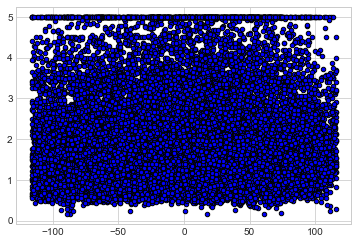

In [103]:
plt.scatter(X_comp[:, 0], y,
            c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [104]:
model = KNeighborsRegressor()
model.fit(X_comp, y)
predict = model.predict(X_comp)

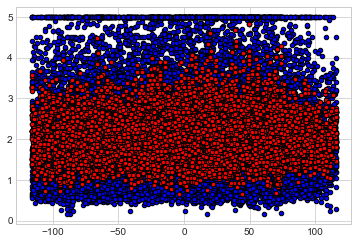

In [105]:
plt.scatter(X_comp[:, 0], y,
            c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k');
plt.scatter(X_comp[:, 0], predict,
            c='r', cmap=plt.cm.coolwarm, s=20, edgecolors='k');